## Demo for the fastMCS toolbox

This notebook provides a demo for the fast implementation of the Model Confidence Set algorithm (`fastMCS`). In particular, it verifies that `fastMCS` produces the same output as the standard eliination MCS as well as demonstrating the ability to update an existing MCS estimation with extra model losses.

Let's start with some standard imports:

In [1]:
import numpy as np

from matplotlib import pyplot as plt
from numpy.random import default_rng
from scipy.stats import norm
from fastMCS import mcs

### Data generating process

The demo is analysis is based on the synthetic data generating process (DGP) used in section 5.1 (page 477) of Hansen et. al. (2011). This is the same analysis as used in the fastMCS manuscript. The loss for model $i$ in observation $n$ is given by:

$$L_{n,i}  = \theta _i  + \frac{a_n}{\sqrt {E\left[ {a_n^2 } \right]} }X_{n,i}$$

Where

$$\left\{ \begin{array}{l}
 \theta _i  = \frac{\lambda }{\sqrt N }\left( {0,\frac{1}{{M - 1}},...,\frac{M - 2}{M - 1},1} \right)  \\
 a_n  = \exp \left( y_n \right) \\
 y_n  =  - \frac{\varphi }{2\left( {1 + \varphi } \right)} + \varphi y_{n - 1}  + \sqrt \varphi  \epsilon _n \\
 \end{array} \right.$$

The behaviour of the losses are controlled by 3 parameters. $\lambda$, controls the dispersion of the mean loss $\theta_i$ of each model, $\rho$ controls the degree of correlation of losses across models and $\varphi$ allows for the possibility of conditional heteroskedasticity (GARCH-like effects) in the losses. The function impleting this DGP is defined below:

In [2]:
def genLosses(lmbda, rho, phi, M, N, seed = 0, shuffle = True):
    """
    Generate synthetic losses for the benchmarking exercise. 

    Parameters
    ----------
    lmbda : float
        Lambda parameter, controls the relative performance of different models
        (higher lambda -> models are easier to distinguish)
    rho : float
        Controls the correlation between model losses.
    phi : float
        Controls the level of conditional heteroskedasticity (GARCH effects) in
        model losses
    M : Int
        Number of models desired
    N : int
        Number of observations
    seed : flaot, optional
        Seed for the random number generator. The default is 0.
    shuffle : boolean, optional
        Controls whether losses are returned ordered or shuffled.
        - If set to False, losses are returned 'as generated', ordered with 
          model 1 displayignt ht lowest average loss and model M the highest.
        - If set to True, columns of L are shuffled so that the average 
          performance of models is randomised
        The default is True.

    Returns
    -------
    L : ndarray
        2D ndarray of synthetic losses. Structure is N x M

    """
    
    rng = default_rng(seed = seed)
    
    theta = lmbda*np.arange(0,M)/((M-1)*N**0.5)

    S = np.ones([M,M])*rho + np.diag(np.ones(M) - rho)
    Sroot = np.linalg.cholesky(S)
    X = Sroot @ norm.ppf(rng.random((M,N)))   # Correlated shocks
    
    e = norm.ppf(rng.random(N+1))
    y = np.zeros(N+1)
    y[0] = -phi/(2*(1+phi)) + e[0]*phi**0.5
    for i in range(1,N+1):
        y[i] = -phi/(2*(1+phi)) + y[i-1]*phi + e[i]*phi**0.5
    
    a = np.exp(y[1:N+1])
    
    L = a[:,None]*X.transpose()
    L /= np.std(L,axis = 0)[None,:]
    L += theta[None,:]
    if shuffle:
        # generate column permutation
        perm = np.arange(0,M)
        rng.shuffle(perm)
        L = L[:,perm]
    
    return L


By default the loss function shuffles the columns of the loss matrix, in order to ensure that the model losses do not possess any systematic ordering in terms of average performance.

To get started, we'll set some parameter values. For $\lambda$, $\rho$ and $\phi$, let's just use the midpoints of the ranges used in the original analysis. The number of models $M$ is set to 500, with $N=$ 250 empirical observations. The number of bootstrap replications $B$ for the analysis is set to 1000, with a block width $b$ of 10. A fixed seed is specified in order to ensure that the various MCS algorithms implemented all use the same set of bootstrap indices.

**NOTE:** When rerunning the notebook and playing around with the number of models, be careful not to increase $M$ too far above 500, as the memory requirements will rapidly grow beyong 8GB.

In [3]:
# Set some parameters and generate losses
lmbda, rho, phi = (22,0.5,0.4)
numMods = 500                   # pick an even number!
numObs = 250
seed = 50
B = 1000
b = 10

# Generate synthetic losses for the comparison exercise
losses = genLosses(lmbda, rho, phi, numMods, numObs, seed = seed)

### Standard elimination MCS

In order to provide a benchmark for the analysis, we need to run the standard elimination MCS. The `fastMCS` module has this as one of the options, selected by setting the `algorithm` option to `'elimination'`. The analysis uses the stationary bootstrap of Politis & Romano (1994) by default, but a standard block bootstrap is available, selected by setting `bootstrap` to `'block'`. The model rankings and corresponding p-values are saved for later comparison against the fast updating algoriothm.

In [4]:
# Run the original elimination MCS
mcsEst0 = mcs(seed = seed)
mcsEst0.addLosses(losses)
mcsEst0.run(B,b, bootstrap = 'stationary', algorithm = 'elimination')

# Get 90% MCS  
incl0, excl0 = mcsEst0.getMCS(alpha = 0.1)
rank0 = np.concatenate((excl0,incl0))
tScore0 = mcsEst0.tScore
pVals0 = mcsEst0.pVals

# Get run time and memory, print output
t0 = mcsEst0.stats[0]['time']       
mem0 = mcsEst0.stats[0]['memory use']*10**-6
print('\n Computational requirements:')
print(' Time (sec): {:.3f}    Memory (MB): {:.3f}'.format(t0,mem0))


───────────────────────────────────────────────────────────────────────────
 Creating new MCS object
───────────────────────────────────────────────────────────────────────────
 Added losses: 250 obs x 500 models
───────────────────────────────────────────────────────────────────────────
 Running elimination MCS analysis

 Computational requirements:
 Time (sec): 123.782    Memory (MB): 6020.027


The `fastMCS` module logs the time taken and memory required in its `stats` attribute. This reveals that the run takes a little bit more than 2 minutes, and required 6GB of RAM.

### 2-pass fastMCS

We now run the 2-pass updating algorithm. The run settings are identical to those used for the elimination implementation, including the seed with which the `mcs` object is initialised. The code below explicitly sets the 2-pass algorithm, however this is also the default for the module. Given that the stationary bootstrap is also the default the same result is obtained if one simply calls:

```
mcsEst2.run(B,b)
```


In [5]:
# Run the 2-pass fast MCS
mcsEst2 = mcs(seed = seed)
mcsEst2.addLosses(losses)
mcsEst2.run(B,b, bootstrap = 'stationary', algorithm = '2-pass')

# Get 90% MCS  
incl2, excl2 = mcsEst2.getMCS(alpha = 0.1)
rank2 = np.concatenate((excl2,incl2))
tScore2 = mcsEst2.tScore
pVals2 = mcsEst2.pVals

# Get run time and memory
t2 = mcsEst2.stats[0]['time']       
mem2 = mcsEst2.stats[0]['memory use']*10**-6
print('\n Computational requirements:')
print(' Time (sec): {:.3f}    Memory (MB): {:.3f}'.format(t2,mem2))

───────────────────────────────────────────────────────────────────────────
 Creating new MCS object
───────────────────────────────────────────────────────────────────────────
 Added losses: 250 obs x 500 models
───────────────────────────────────────────────────────────────────────────
 Running 2-pass MCS analysis

 Computational requirements:
 Time (sec): 3.609    Memory (MB): 22.008


The time and memory diagnostics reveal a dramatic improvement. The run took just under 4 seconds and only required 22MB of RAM. This results from the polynomial order reduction in time complexity and memory requirement brought on by the 2-pass updating fastMCS algorithm, reducing the former from $\mathcal{O}(M^3)$ to $\mathcal{O}(M^2)$ and the latter from $\mathcal{O}(M^2)$ to $\mathcal{O}(M)$.

Having obtained the model rankings and p-values produced by the 2-pass updating fastMCS algorithm, we can quickly check that they match those produced by the elimination verson:

In [6]:
# Compare model rankings and P-values
print('\n Model rankings the same as elimination? - {}'.format(
        np.array_equal(rank2,rank0))
      )
print(' Model p-values the same as elimination? - {}'.format(
        np.array_equal(pVals2,pVals0))
     )
print(' Mean absolute deviation in P-values from elimination: {:.3f}'.format(
        np.mean(np.abs(pVals2-pVals0)))
      )


 Model rankings the same as elimination? - True
 Model p-values the same as elimination? - True
 Mean absolute deviation in P-values from elimination: 0.000


### Updating an existing MCS analysis with the 1-pass fastMCS

The inutition behind the fastMCS implementation is to reverse the standard elimination procedure: rather than start with a full collection of models and iteratively eliminate the workt perofming, the algorithm instead starts with a one-model collection and iteratively adds models to it, updating the eminination statistics and associated p-values. As a result, it becomes possible to process a collection of models in multiple stemps, opening the possibility of  large-scale collaborative comparisions.

In order to illustrate this, the original loss matrix is split into two parts, and the the 2-pass `fastMCS` module is used to analyise the first half.

In [7]:
# Run an updating demonstration
losses_1 = losses[:,0:int(numMods/2)]
losses_2 = losses[:,int(numMods/2):numMods]

# Run the 2-pass fast MCS on the first part of the losses
mcsEst1 = mcs(seed = seed)
mcsEst1.addLosses(losses_1)
mcsEst1.run(B,b, bootstrap = 'stationary', algorithm = '2-pass')

# Get run time and memory
t1 = mcsEst1.stats[0]['time']       
mem1 = mcsEst1.stats[0]['memory use']*10**-6
print('\n Computational requirements(losses_1):')
print(' Time (sec): {:.3f}    Memory (MB): {:.3f}'.format(t1,mem1))

───────────────────────────────────────────────────────────────────────────
 Creating new MCS object
───────────────────────────────────────────────────────────────────────────
 Added losses: 250 obs x 250 models
───────────────────────────────────────────────────────────────────────────
 Running 2-pass MCS analysis

 Computational requirements(losses_1):
 Time (sec): 0.912    Memory (MB): 11.497


The current `mcsEst1` object, containing the analysis can be saved using the `mcsEst1.save(...)` method and shared with others. Creating a new object and using the `.load(...)` method recovers the analysis, which can be updated as illustrated below.

The first step is to add losses to the object, which are appended to the existing one (in this case, the second half of the original loss matrix). Note that an error is raised if the number of observations doesn't match the existing losses. Using the `.run()` method with update the existing MCS analysis using the 1-pass algorithm onn the new losses alone.

In [8]:
# Update the existing MCS with the second part of losses
mcsEst1.addLosses(losses_2)
mcsEst1.run(B,b)            # This will run with the 1-pass method

# Get 90% MCS  
incl1, excl1 = mcsEst1.getMCS(alpha = 0.1)
rank1 = np.concatenate((excl1,incl1))
tScore1 = mcsEst1.tScore
pVals1 = mcsEst1.pVals

# Get run time and memory
t1 = mcsEst1.stats[-1]['time']       
mem1 = mcsEst1.stats[-1]['memory use']*10**-6
print('\n Computational requirements (losses_2):')
print(' Time (sec): {:.3f}    Memory (MB): {:.3f}'.format(t1,mem1))

───────────────────────────────────────────────────────────────────────────
 Added losses: 250 obs x 250 models
───────────────────────────────────────────────────────────────────────────
 Updating existing MCS analysis
  No of existing models:   250
  No of additional models: 250
 Running 1-pass MCS analysis

 Computational requirements (losses_2):
 Time (sec): 2.163    Memory (MB): 22.027


The overall runtime over the two runs and the memory requirement are same as that of the 2-pass implementation. We can again compare the rankings and p-values, as we did for the 2-pass implementation above. 

In [9]:
# Compare model rankings and P-values
print('\n Model rankings the same as elimination? - {}'.format(
        np.array_equal(rank1,rank0))
      )
print(' Model p-values the same as elimination? - {}'.format(
        np.array_equal(pVals1,pVals0))
     )
print(' Mean absolute deviation in P-values from elimination: {:.3f}'.format(
        np.mean(np.abs(pVals1-pVals0)))
      )


 Model rankings the same as elimination? - True
 Model p-values the same as elimination? - False
 Mean absolute deviation in P-values from elimination: 0.001


While the model rankings obtained with the 1-pass algorithm, processed in two discrete runs, are identical to those obtained with the elimination approach, the p-values no longer match ***exactly***.

This is due to the fact that updating the bootstrapped p-values requires stronger assumptions on the stablility of model rankings from iteration to iteration than the updating of the emilination statistics themselves. For the theoretical details of why this is the case, see Barde (2024).

The 2-pass algorithm gets around the problem by processing the p-values in a second pass, once the model rankings have been obtained. This is not possible when updating rankings and p-values in the same pass, therefore the 1-pass algorithm uses a heuristic instead, which explains the slight difference in the p-values.

The plot below shows the different p-values obtained wiith the three algorithms over the selimination sequence (models ranked worst to best), in order to better visualise the discrepancy. The p-values of the elimination and 2-pass algorithms (in blue and black respectively) cannot be distinguished. They do not correspiond exactly to the p-values obtained using the 1-pass algorithm, in red, however the difference between the two is negligeable, confirming the effectiveness of the heuristic.

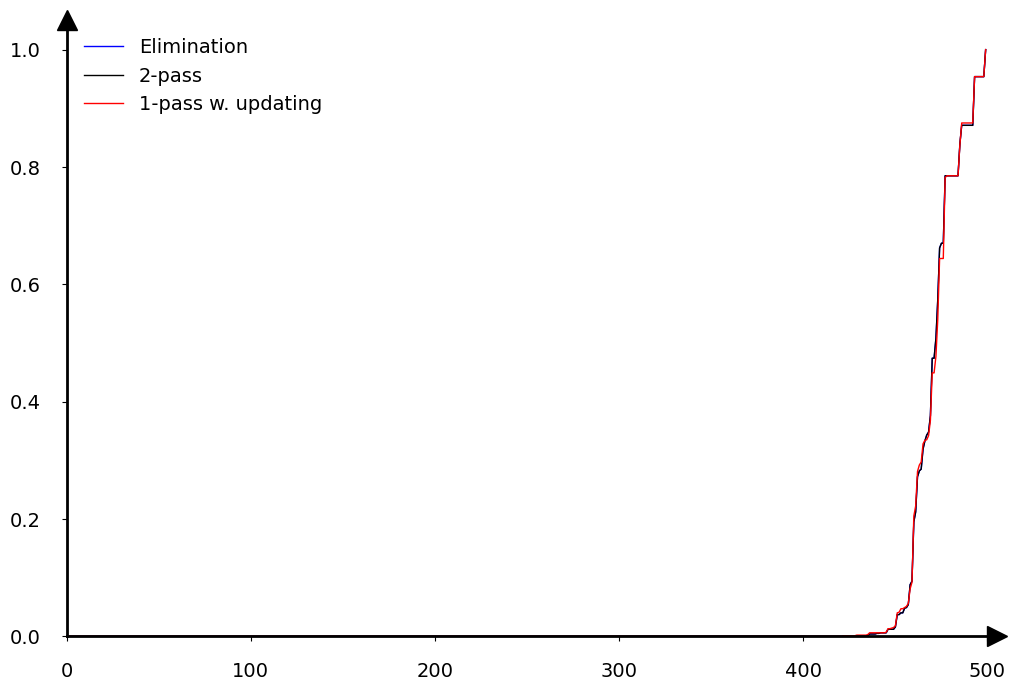

In [10]:
# Generate plots
fontSize = 14
y_min, y_max = (0,1.05)
x_min, x_max = (0,numMods+5)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(pVals0,'b', linewidth=1, label = r'Elimination')
ax.plot(pVals2,'k', linewidth=1, label = r'2-pass')
ax.plot(pVals1,'r', linewidth=1, label = r'1-pass w. updating')

ax.legend(loc='upper left', frameon=False, prop={'size':fontSize})
ax.set_ylim(top = y_max, bottom = y_min)
ax.set_xlim(left = x_min,right = x_max)
ax.plot(x_max, y_min, ">k", ms=15, clip_on=False)
ax.plot(x_min, y_max, "^k", ms=15, clip_on=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='x', pad=15, labelsize=fontSize)
ax.tick_params(axis='y', pad=15, labelsize=fontSize)

### References:

- Barde, S, 2024. Large-scale model comparison with fast model confidence sets, *preprint* 
- Hansen, P.R., Lunde, A. and Nason, J.M., 2011. The model confidence set. *Econometrica*, 79(2), pp.453-497.
- Politis, D.N. and Romano, J.P., 1994. The stationary bootstrap. *Journal of the American Statistical association*, 89(428), pp.1303-1313.